## Load Dataset

In [53]:
import psycopg2
import pandas as pd
import json

# Connessione al database
conn = psycopg2.connect(
    dbname="scientilla",
    user="postgres",
    password="pwd",
    host="localhost",
    port=5444
)

# Query
query = """
SELECT ri.data
FROM research_item AS ri
JOIN research_item_type AS rit
    ON ri.research_item_type_id = rit.id
WHERE rit.type = 'publication'
ORDER BY ri.id
LIMIT 1000;
"""

# Leggi il risultato come DataFrame
df = pd.read_sql(query, conn)
print(df)

data_array = df["data"].tolist()[:1000]


                                                  data
0    {'doi': '10.1016/j.jconrel.2011.10.021', 'year...
1    {'doi': '10.1002/adfm.202400982', 'year': '202...
2    {'doi': '10.1016/j.jnucmat.2024.155121', 'year...
3    {'doi': '10.1103/PhysRevB.94.165155', 'year': ...
4    {'doi': '10.1039/c2jm15117k', 'year': '2012', ...
..                                                 ...
995  {'doi': '10.1038/s41598-017-03882-8', 'year': ...
996  {'doi': '10.1038/srep00630', 'year': '2012', '...
997  {'doi': '10.1016/S0223-5234(99)80045-2', 'year...
998  {'doi': '10.1209/0295-5075/25/5/005', 'year': ...
999  {'doi': '10.1073/pnas.1121626109', 'year': '20...

[1000 rows x 1 columns]


/tmp/ipykernel_21411/1331918952.py:26: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


## Preprocessing

In [54]:
def clean_item(item):
    year = item.get("year") or ""
    title = item.get("title") or ""
    abstract = item.get("abstract") or ""
    title = item.get("title") or ""
    abstract = item.get("abstract") or ""
    if abstract:
      text = f"{title}. {abstract}. {year}"
    else:
      text = f"{title}. {year}"
    return text.strip()

cleaned_strings = [clean_item(d) for d in data_array]

for s in cleaned_strings:
    print(s)

Rapid tumoritropic accumulation of systemically injected plateloid particles and their biodistribution. Nanoparticles for cancer therapy and imaging are designed to accumulate in the diseased tissue by exploiting the Enhanced Permeability and Retention (EPR) effect. This limits their size to about 100 nm. Here, using intravital microscopy and elemental analysis, we compare the in vivo localization of particles with different geometries and demonstrate that plateloid particles preferentially accumulate within the tumor vasculature at unprecedented levels, independent of the EPR effect. In melanoma-bearing mice, 1000 × 400 nm plateloid particles adhered to the tumor vasculature at about 5% and 10% of the injected dose per gram organ (ID/g) for untargeted and RGD-targeted particles respectively, and exhibited the highest tumor-to-liver accumulation ratios (0.22 and 0.35). Smaller and larger plateloid particles, as well as cylindroid particles, were more extensively sequestered by the live

## Dataset Embedding Generation

In [55]:
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
import numpy as np

model = SentenceTransformer("sentence-transformers/allenai-specter")

doc_texts = [json.dumps(d, ensure_ascii=False) for d in data_array]
doc_ids = [d.get("doi") or f"idx_{i}" for i, d in enumerate(data_array)]

doc_embeddings = model.encode(
    doc_texts,
    convert_to_numpy=True,
    normalize_embeddings=True
)

np.save("embeddings/doc_embeddings_specter2.npy", doc_embeddings)

with open("doc_ids.json", "w", encoding="utf-8") as f:
    json.dump(doc_ids, f, ensure_ascii=False, indent=2)

print("Saved doc_embeddings.npy and doc_ids.json")


Saved doc_embeddings.npy and doc_ids.json


### Clustering

/tmp/ipykernel_21411/3345095364.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab10", n_clusters)


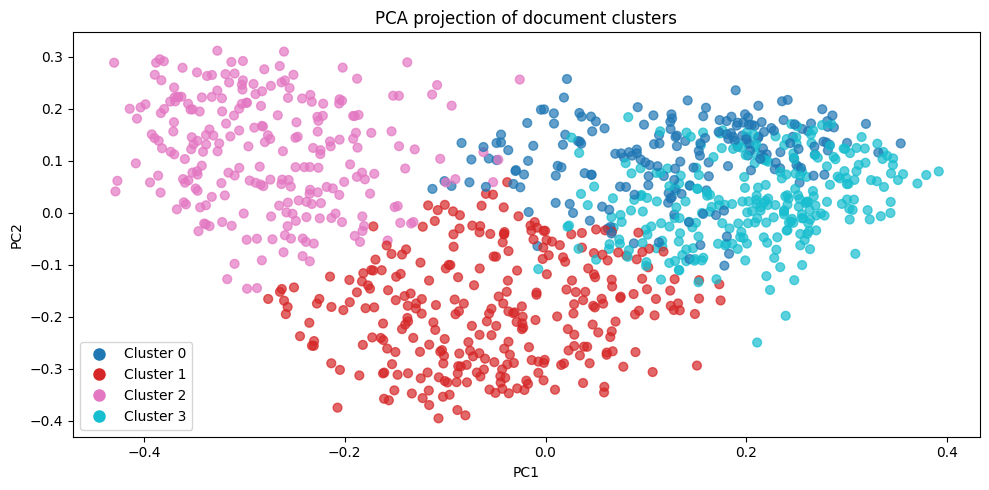


=== Cluster 0 ===
- Colloidal-Doped Semiconductor Nanocrystals Embedded in One-Dimensional Photonic Crystals for Ultrafast Photonics
- All-optical reversible actuation of photochromic-polymer microsystems
- Comparative study of the photochemical modifications effected in the UV laser ablation of doped polymer substrates
- Numerical study of transient absorption saturation in single-layer graphene for optical nanoscopy applications
- Photochemical effects in the UV laser ablation of polymers: Implications for laser restoration of painted artworks
- UV laser ablation of halonaphthalene-doped PMMA: Chemical modifications above versus below the ablation threshold
- Ultra-fast polariton dynamics in an organic microcavity
- Light-driven liquid microlenses
- Brillouin and Umklapp scattering in polybutadiene: Comparison of neutron and x-ray scattering
- Amplified spontaneous emission from opal photonic crystals engineered with structural defects
- Functional photonic-crystal mini-stop band de

In [56]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.cm as cm

titles = [d.get("title") or "" for d in data_array]  # extract titles

n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels = kmeans.fit_predict(doc_embeddings)

cmap = cm.get_cmap("tab10", n_clusters)
colors = [cmap(l) for l in labels]

pca = PCA(n_components=2, random_state=42)
emb_2d = pca.fit_transform(doc_embeddings)

plt.figure(figsize=(10, 5))
plt.scatter(
    emb_2d[:, 0],
    emb_2d[:, 1],
    color=colors,
    s=40,
    alpha=0.7
)


plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA projection of document clusters")

unique_labels = np.unique(labels)
handles = [
    plt.Line2D([], [], marker="o", linestyle="", markersize=8,
               label=f"Cluster {l}", color=cmap(l))
    for l in unique_labels
]
plt.legend(handles=handles, loc="best")

plt.tight_layout()
plt.show()

# Print documents grouped by cluster
for c in range(n_clusters):
    print(f"\n=== Cluster {c} ===")
    indices = np.where(labels == c)[0]
    for idx in indices:
        print(f"- {titles[idx]}")


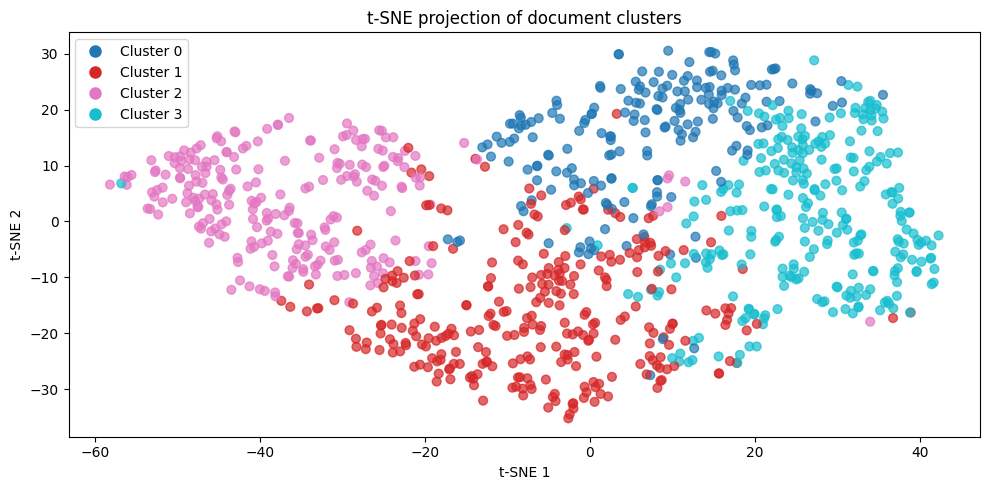

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate='auto',
    init='random',
    random_state=42
)
emb_2d_tsne = tsne.fit_transform(doc_embeddings)

plt.figure(figsize=(10, 5))
plt.scatter(
    emb_2d_tsne[:, 0],
    emb_2d_tsne[:, 1],
    color=colors,
    s=40,
    alpha=0.7
)

plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.title("t-SNE projection of document clusters")

unique_labels = np.unique(labels)
handles = [
    plt.Line2D([], [], marker="o", linestyle="", markersize=8,
               label=f"Cluster {l}", color=cmap(l))
    for l in unique_labels
]
plt.legend(handles=handles, loc="best")

plt.tight_layout()
plt.show()


## Load Embeddings

In [69]:
import numpy as np
import json
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

model = SentenceTransformer("sentence-transformers/allenai-specter")

doc_embeddings = np.load("embeddings/doc_embeddings_specter2.npy")

with open("doc_ids.json", "r", encoding="utf-8") as f:
    doc_ids = json.load(f)


## Testing

In [70]:
from sklearn.metrics.pairwise import cosine_similarity

def search(query, top_k=5):
    q_emb = model.encode([query], convert_to_numpy=True, normalize_embeddings=True)
    sims = cosine_similarity(q_emb, doc_embeddings)[0]

    ranked = np.argsort(-sims)
    k = min(top_k, len(ranked))

    print(f"\n=== Query: {query!r} ===")
    for i in range(k):
        idx = ranked[i]
        score = sims[idx]
        doc_id = doc_ids[idx]
        text = cleaned_strings[idx]

        print(f"\n[{i+1}] id={doc_id}  score={score:.3f}")
        print(f"     text: {text[:200]}{'...' if len(text) > 200 else ''}")


In [74]:
test_queries = ['renewable energies','heart', 'cardiology', 'nature','biology']

for q in test_queries:
    search(q, top_k=5)


=== Query: 'renewable energies' ===

[1] id=10.24084/repqj18.391  score=0.753
     text: Cheap and easily processable electrode/electrolytes for next-generation sodium-ion batteries. Electrochemical energy storage is of increasing importance to allow large-scale integration of intermitten...

[2] id=10.1103/PhysRevB.99.035421  score=0.745
     text: Charger-mediated energy transfer for quantum batteries: An open-system approach. The energy charging of a quantum battery is analyzed in an open quantum setting, where the interaction between the batt...

[3] id=10.3190/jgeosci.300  score=0.723
     text: A new solvothermal approach to obtain nanoparticles in the Cu3SnS4–Cu2FeSnS4 join. In the field of the renewables, a large effort has been devoted in the last years to obtain conventional and new mate...

[4] id=10.1016/j.fuel.2015.02.081  score=0.719
     text: Bio-oil from pyrolysis of wood pellets using a microwave multimode oven and different microwave absorbers. Wood pellets were pyr

## Adapters

In [ ]:
import torch
import numpy as np
import json
from transformers import AutoTokenizer
from adapters import AutoAdapterModel

tokenizer = AutoTokenizer.from_pretrained("allenai/specter2_base")
model = AutoAdapterModel.from_pretrained("allenai/specter2_base")


model.load_adapter(
    "allenai/specter2",
    source="hf",
    load_as="specter2",
    set_active=True
)

papers = data_array 
texts = [
    d["title"] + tokenizer.sep_token + (d.get("abstract") or "")
    for d in papers
]

def encode_specter2(texts, batch=16):
    model.eval()
    all_vecs = []

    with torch.no_grad():
        for i in range(0, len(texts), batch):
            chunk = texts[i:i+batch]

            inp = tokenizer(
                chunk,
                padding=True,
                truncation=True,
                max_length=512,
                return_tensors="pt",
                return_token_type_ids=False
            )

            out = model(**inp)
            emb = out.last_hidden_state[:, 0, :]
            all_vecs.append(emb.cpu().numpy())

    return np.vstack(all_vecs)

embeddings = encode_specter2(texts)
print("Embeddings shape:", embeddings.shape)

np.save("specter2_embeddings.npy", embeddings)

with open("specter2_papers.json", "w", encoding="utf-8") as f:
    json.dump(papers, f, ensure_ascii=False, indent=2)


Fetching 4 files: 100%|██████████| 4/4 [00:00<00:00, 11522.81it/s]
There are adapters available but none are activated for the forward pass.


Embeddings shape: (1000, 768)


/tmp/ipykernel_21411/1281717720.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab10", n_clusters)


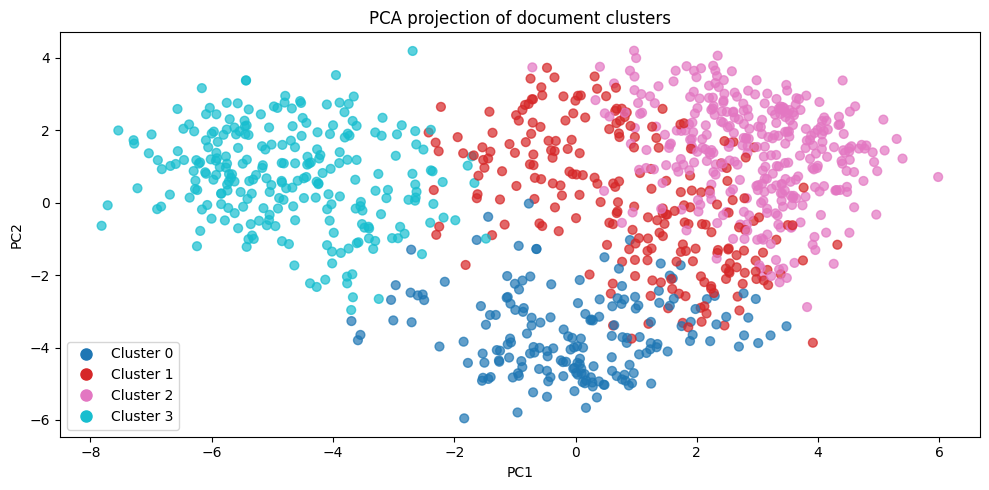


=== Cluster 0 ===
- Rapid tumoritropic accumulation of systemically injected plateloid particles and their biodistribution
- Mechanisms of alpha-synuclein action on neurotransmission: Cell-autonomous and non-cell autonomous role
- On the Synergistic Effects of Ligand-Mediated and Phage-Intrinsic Properties During In Vivo Selection
- Effects of subacute toluene exposure on protein phosphorylation levels in rat frontoparietal and striatal membranes
- Effects of sustained hyperprolactinemia inducedby chronic treatment with domperidone on central dopaminergic systems in the rat
- dSysMap: Exploring the edgetic role of disease mutations
- RNA: The Unsuspected Conductor in the Orchestra of Macromolecular Crowding
- Neuropeptide Y (NPY) and adrenaline (A) interactions in the central control of arterial blood pressure (ABP) in the male rat
- Effect of Ivabradine in dilated cardiomyopathy from Duchenne muscular dystrophy: A chance for slowing progression of heart failure?
- Sex dimorphism cont

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.cm as cm

titles = [d.get("title") or "" for d in data_array]

n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels = kmeans.fit_predict(embeddings)

cmap = cm.get_cmap("tab10", n_clusters)
colors = [cmap(l) for l in labels]

pca = PCA(n_components=2, random_state=42)
emb_2d = pca.fit_transform(embeddings)

plt.figure(figsize=(10, 5))
plt.scatter(
    emb_2d[:, 0],
    emb_2d[:, 1],
    color=colors,
    s=40,
    alpha=0.7
)


plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA projection of document clusters")

unique_labels = np.unique(labels)
handles = [
    plt.Line2D([], [], marker="o", linestyle="", markersize=8,
               label=f"Cluster {l}", color=cmap(l))
    for l in unique_labels
]
plt.legend(handles=handles, loc="best")

plt.tight_layout()
plt.show()

for c in range(n_clusters):
    print(f"\n=== Cluster {c} ===")
    indices = np.where(labels == c)[0]
    for idx in indices:
        print(f"- {titles[idx]}")


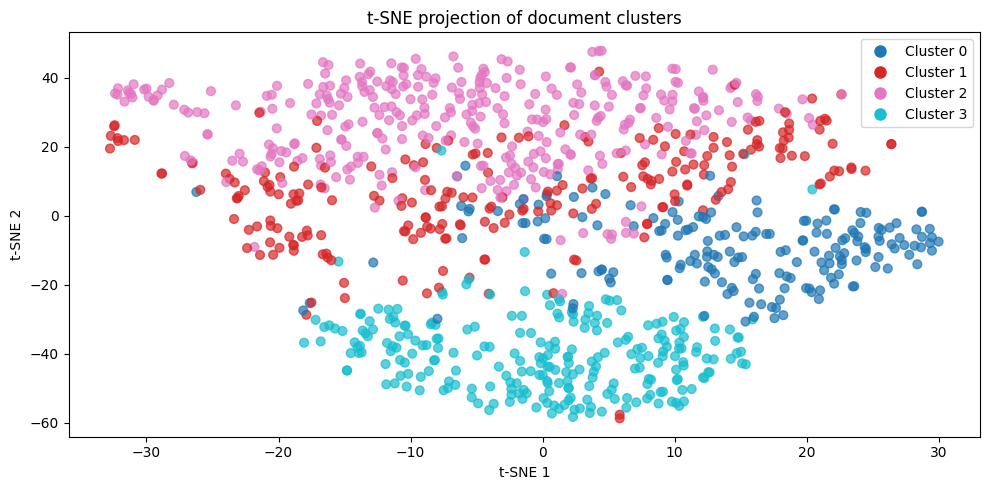

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate='auto',
    init='random',
    random_state=42
)
emb_2d_tsne = tsne.fit_transform(embeddings)

plt.figure(figsize=(10, 5))
plt.scatter(
    emb_2d_tsne[:, 0],
    emb_2d_tsne[:, 1],
    color=colors,
    s=40,
    alpha=0.7
)

plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.title("t-SNE projection of document clusters")

unique_labels = np.unique(labels)
handles = [
    plt.Line2D([], [], marker="o", linestyle="", markersize=8,
               label=f"Cluster {l}", color=cmap(l))
    for l in unique_labels
]
plt.legend(handles=handles, loc="best")

plt.tight_layout()
plt.show()


In [64]:
import numpy as np
import json

embeddings = np.load("specter2_embeddings.npy")

with open("specter2_papers.json", "r", encoding="utf-8") as f:
    papers = json.load(f)


In [65]:
from sklearn.metrics.pairwise import cosine_similarity

def encode_query(query):
    inp = tokenizer(
        [query],
        padding=True,
        truncation=True,
        max_length=512,
        return_tensors="pt",
        return_token_type_ids=False
    )
    with torch.no_grad():
        out = model(**inp)
    return out.last_hidden_state[:, 0, :].cpu().numpy()


In [68]:
def search(query, top_k=5):
    q_emb = encode_query(query)
    sims = cosine_similarity(q_emb, embeddings)[0]
    idx = np.argsort(-sims)[:top_k]

    print(f"\n=== Query: {query} ===")
    for i, j in enumerate(idx):
        print(f"\n[{i+1}] score={sims[j]:.4f}")
        print("title:", papers[j]["title"])
        print("abstract:", (papers[j].get("abstract") or "")[:300], "...")

search("Renewable energies", top_k=7)



=== Query: Renewable energies ===

[1] score=0.9293
title: Innovative micro- and nanostructured materials and devices for energy applications
abstract:  ...

[2] score=0.9061
title: Series preface
abstract:  ...

[3] score=0.9061
title: Series preface
abstract:  ...

[4] score=0.9044
title: Erratum to: Optical nanoscopy (La Rivista del Nuovo Cimento, (2020), 43, 8, (385-455), 10.1007/s40766-020-00008-1)
abstract: After publication of the article we noticed that equations number 24 and 25 missed a convolution sign. ...

[5] score=0.8987
title: Fully Screen-Printed, Flexible, and Scalable Organic Monolithic Thermoelectric Generators
abstract: Energy-harvesting technologies offer a sustainable, maintenance-free alternative to conventional energy-storage solutions in distributed low-power applications. Flexible thermoelectric generators (TEGs) can generate electric power from a temperature gradient, even on complex surfaces. Organic materi ...

[6] score=0.8977
title: Preface
abstract:  .